In [ ]:
# Uncomment the line below to install Aer package for custom depolarizing error
# !pip install qiskit-aer

In [9]:
from qiskit import QuantumCircuit, QuantumRegister, transpile
import numpy as np
from qiskit.providers.fake_provider import FakeProvider
from qiskit.circuit.library import CZGate, RXGate, RYGate, UnitaryGate, TGate, XGate, YGate, CPhaseGate, HGate
from qiskit.quantum_info import Statevector, Operator
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, QuantumError, depolarizing_error

In [10]:
# Define the gates
X90, Y90 = RXGate(np.pi / 2), RYGate(np.pi / 2)
T, X, Y, H = TGate(), XGate(), YGate(), HGate()
SW = UnitaryGate((np.sqrt((X.to_matrix() + Y.to_matrix())/np.sqrt(2))), label='SW')
XY90 = UnitaryGate((X90.to_matrix() + Y90.to_matrix()) / np.sqrt(3), label="XY90")
XY90mm = UnitaryGate((-X90.to_matrix() - Y90.to_matrix()) / np.sqrt(3), label="XY90mm")
XY90pm = UnitaryGate((X90.to_matrix() - Y90.to_matrix()), label="XY90pm")
XY90mp = UnitaryGate((-X90.to_matrix() + Y90.to_matrix()), label="XY90mp")
CZ, CP = CZGate(), CPhaseGate(np.pi/2)

# Possible gate sets
gate_dict1 = {0: X90, 1: Y90, 2: T}  # https://arxiv.org/abs/1608.00263
gate_dict2 = {0: X90, 1: Y90, 2: SW}  # https://www.nature.com/articles/s41586-019-1666-5
gate_dict3 = {0: X90, 1: Y90, 2: XY90, 3: XY90mm, 4: XY90pm, 5: XY90mp} # https://arxiv.org/abs/2001.08343
gate_dict4 = {0: X90, 1: Y90, 2: XY90} 
gate_sets = [gate_dict1, gate_dict2, gate_dict3, gate_dict4]

# Choose the gate set
gate_set_choice = 4 # 1, 2, 3 or 4
gate_dict = gate_sets[gate_set_choice - 1]
random_gates = len(gate_dict)

In [11]:
depol_error = depolarizing_error(0.1, 2)
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(depol_error, ["cz"])
# backend = AerSimulator(noise_model=noise_model) 
backend = FakeProvider().get_backend("fake_valencia")

In [12]:
# np.random.seed(335)
sequences = 150 # Number of sequences
max_depth = 17 # Maximum depth
step = 1 # Step for depths to be tested
depths = np.arange(2, max_depth + 1, step) # Depths to be tested
n_avgs = 101 # Number of shots
np.random.seed(12321)
qubits = QuantumRegister(2, "q") # Number of qubits

sq_gates, counts_list, states_list, circuits_list = [], [], [], []  # 2D for 2 qubits

# Generate sequences
for s in range(sequences):  # For each sequence
    counts_list.append([])
    sq_gates.append([])
    circuits_list.append([])
    states_list.append([])
    for i, d in enumerate(depths):  # For each maximum depth
        sq_gates[s].append(np.zeros((2, d), dtype=int))
        for q in range(2):  # For each qubit
            # Generate random single qubit gates
            # Start the sequence with a random gate
            sq_gates[s][i][q][0] = np.random.randint(random_gates)
        for d_ in range(1, d):  # For each growing depth (all cycles until maximum depth d)
            for q in range(2):  # For each qubit
                sq_gates[s][i][q][d_] = np.random.randint(random_gates)
                # Make sure that the same gate is not applied twice in a row
                while sq_gates[s][i][q][d_] == sq_gates[s][i][q][d_ - 1]:
                    sq_gates[s][i][q][d_] = np.random.randint(random_gates)
        # Define the circuit
        qc = QuantumCircuit(qubits)
        # qc.append(H, [0])
        # qc.append(H, [1])
        for d_ in range(d):  # Apply layers
            for q in range(2):  # For each qubit, append single qubit gates
                qc.append(gate_dict[sq_gates[s][i][q][d_]], [qubits[q]])
            # Apply CZ gate
            # qc.append(CZ, qubits)
        # Store the statevector
        states_list[s].append(Statevector(qc))
        circuits_list[s].append(qc)
        

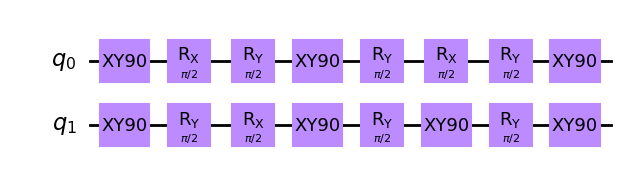

In [13]:
# Draw the circuit of your choice: first index is the sequence, second index is the depth index in depths array
circuits_list[1][6].draw(output="mpl", style='clifford')

In [14]:
# Execute circuit (transpiled) and store counts
for s in range(sequences):
    for i, d in enumerate(depths):
        qc2 = transpile(circuits_list[s][i].measure_all(inplace=False), backend)
        job = backend.run(qc2, shots=n_avgs)
        counts = job.result().get_counts()

        # Add missing keys to counts (Qiskit does not add all possible outcomes by default, only the ones carrying actual counts)
        for key in [bin(i)[2:].zfill(2) for i in range(2 ** len(qubits))]:
            if key not in counts.keys():
                counts[key] = 0
        # Add counts to list
        counts_list[s].append(counts)
        

In [15]:
def cross_entropy(p, q, epsilon=1e-15):
    """
    Calculate cross entropy between two probability distributions.

    Parameters:
    - p: numpy array, the true probability distribution
    - q: numpy array, the predicted probability distribution
    - epsilon: small value to avoid taking the logarithm of zero

    Returns:
    - Cross entropy between p and q
    """
    q = np.maximum(q, epsilon)  # Avoid taking the logarithm of zero

    # print(f"p: {p}, \nq: {q}")

    x_entropy = -np.sum(p * np.log(q))

    return x_entropy

In [16]:
from scipy.optimize import curve_fit
# Post-processing
records = []
incoherent_dist = np.ones(2** len(qubits)) / 2 ** len(qubits)
fidelities = np.zeros((sequences, len(depths)))
expected_probs = np.zeros((sequences, len(depths), 2 ** len(qubits)))
measured_probs = np.zeros((sequences, len(depths), 2 ** len(qubits)))

# Reconstruct sequence from gate indices (similar step to what is done in QUA)
for s in range(sequences):
    for j, d in enumerate(depths):
        qc = QuantumCircuit(qubits)
        # qc.append(H, [0])
        # qc.append(H, [1])
        for k in range(d):
            sq_gate1, sq_gate2 = (
                gate_dict[sq_gates[s][j][0][k]],
                gate_dict[sq_gates[s][j][1][k]],
            )
            # Retrieve random single qubit gates applied on both qubits
            # Apply the gates on the state
            qc.append(sq_gate1, [0])
            qc.append(sq_gate2, [1])
            # qc.append(CZ, [0, 1])
            # print("computed state: %s" % state)
        expected_probs[s, j] = Statevector(qc).probabilities()
        # print("reconstructed probs", expected_probs[s, j])
        # print("state based probs", states_list[s][j].probabilities())
        measured_probs[s, j] = (
            np.array([counts_list[s][j][bit] for bit in ["00", "01", "10", "11"]])
            / n_avgs
        )
        # print("measured", measured_probs[s, j])
        xe_incoherent = cross_entropy(incoherent_dist, expected_probs[s, j])
        xe_measured = cross_entropy(measured_probs[s, j], expected_probs[s, j])
        xe_expected = cross_entropy(expected_probs[s, j], expected_probs[s, j])

        f_xeb = (xe_incoherent - xe_measured) / (xe_incoherent - xe_expected)
        fidelities[s, j] = f_xeb
        print(f"seq {s + 1}, depth {depths[j]}: f_xeb = {f_xeb}")
        records += [
            {
                "sequence": s,
                "depth": depths[j],
                "pure_probs": expected_probs[s, j],
                # "pure_probs": states_list[s][j].probabilities(),
                "sampled_probs": measured_probs[s, j],
                "circuit": circuits_list[s][j],
            }
        ]

for record in records:
    e_u = np.sum(record["pure_probs"] ** 2)
    u_u = np.sum(record["pure_probs"]) / 2 ** len(qubits)
    m_u = np.sum(record["pure_probs"] * record["sampled_probs"])
    record.update(e_u=e_u, u_u=u_u, m_u=m_u)

seq 1, depth 2: f_xeb = 0.9356435643564359
seq 1, depth 3: f_xeb = 0.7722772277227724
seq 1, depth 4: f_xeb = 1.2252475247524797
seq 1, depth 5: f_xeb = 1.180693069306933
seq 1, depth 6: f_xeb = 1.114561727881927
seq 1, depth 7: f_xeb = 1.0544554455445547
seq 1, depth 8: f_xeb = 0.9356435643564375
seq 1, depth 9: f_xeb = 1.0117966884683411
seq 1, depth 10: f_xeb = 0.6533020400183422
seq 1, depth 11: f_xeb = 1.0208847584163254
seq 1, depth 12: f_xeb = 0.25016496362380636
seq 1, depth 13: f_xeb = 0.8465346534653478
seq 1, depth 14: f_xeb = 0.9207910090783379
seq 1, depth 15: f_xeb = 0.8794403682867502
seq 1, depth 16: f_xeb = 0.8957162222800998
seq 1, depth 17: f_xeb = 0.9130771579187587
seq 2, depth 2: f_xeb = 1.0
seq 2, depth 3: f_xeb = 0.9207920792079209
seq 2, depth 4: f_xeb = 1.0789425624815279
seq 2, depth 5: f_xeb = 0.9059405940594073
seq 2, depth 6: f_xeb = 0.824257425742578
seq 2, depth 7: f_xeb = 0.969059405940595
seq 2, depth 8: f_xeb = 0.7544068347304721
seq 2, depth 9: f_xeb

/var/folders/lz/657q9ypj0pd6l1g7f0wk81hm0000gn/T/ipykernel_98184/240709089.py:38: RuntimeWarning: invalid value encountered in scalar divide
  f_xeb = (xe_incoherent - xe_measured) / (xe_incoherent - xe_expected)
/var/folders/lz/657q9ypj0pd6l1g7f0wk81hm0000gn/T/ipykernel_98184/240709089.py:38: RuntimeWarning: divide by zero encountered in scalar divide
  f_xeb = (xe_incoherent - xe_measured) / (xe_incoherent - xe_expected)


seq 22, depth 15: f_xeb = 0.8287096258855677
seq 22, depth 16: f_xeb = 0.9319263978226126
seq 22, depth 17: f_xeb = 0.9632198190806559
seq 23, depth 2: f_xeb = 1.0247524752475252
seq 23, depth 3: f_xeb = 0.8939826869390161
seq 23, depth 4: f_xeb = 1.0131094582624744
seq 23, depth 5: f_xeb = 1.00580151859148
seq 23, depth 6: f_xeb = 0.9356435643564357
seq 23, depth 7: f_xeb = 1.099622475598295
seq 23, depth 8: f_xeb = 0.8153752263764116
seq 23, depth 9: f_xeb = 0.9504950495049502
seq 23, depth 10: f_xeb = 1.0177411443435314
seq 23, depth 11: f_xeb = 1.1287128712871306
seq 23, depth 12: f_xeb = 0.9759424529659004
seq 23, depth 13: f_xeb = 0.8435143095046423
seq 23, depth 14: f_xeb = 0.8459791116268773
seq 23, depth 15: f_xeb = 0.910473708494022
seq 23, depth 16: f_xeb = 0.8186262407507732
seq 23, depth 17: f_xeb = 0.9842157788189845
seq 24, depth 2: f_xeb = 0.8465346534653464
seq 24, depth 3: f_xeb = 0.9601270492109458
seq 24, depth 4: f_xeb = 1.0990099009901055
seq 24, depth 5: f_xeb = 

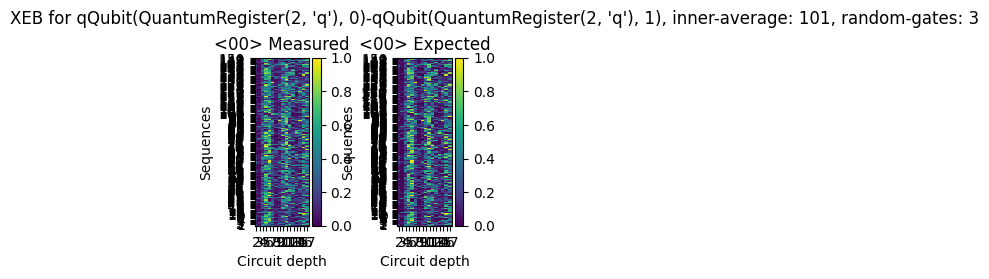

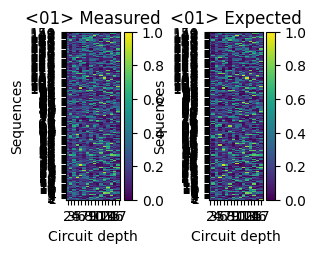

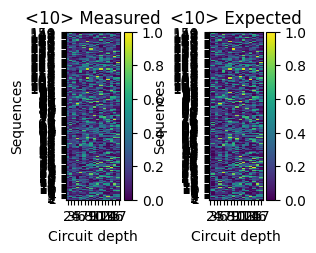

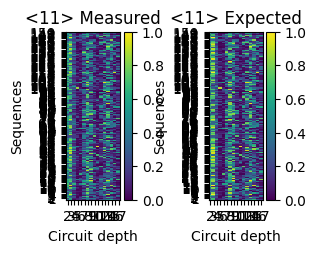

In [17]:
# Plot the results
def create_subplot(data, subplot_number, title):
    plt.subplot(subplot_number)
    plt.pcolor(depths, range(sequences), np.abs(data), vmin=0., vmax=1.0)
    ax = plt.gca()
    ax.set_title(title)
    ax.set_xlabel("Circuit depth")
    ax.set_ylabel("Sequences")
    ax.set_xticks(depths)
    ax.set_yticks(np.arange(1, sequences + 1))
    plt.colorbar()

titles, data = [], []

for i in range(4):
    titles.append(f"<{bin(i)[2:].zfill(2)}> Measured")
    titles.append(f"<{bin(i)[2:].zfill(2)}> Expected")
    data.append(measured_probs[:, :, i])
    data.append(expected_probs[:, :, i])

plot_number = [241, 242, 243, 244, 245, 246, 247, 248]

k = 0
for title, d, n in zip(titles, data, plot_number):

    if k%2 == 0:
        plt.figure()
    if k==0:
            plt.suptitle(f"XEB for q{qubits[0]}-q{qubits[1]}, inner-average: {n_avgs}, random-gates: {3}")
    create_subplot(d, n, title)
    plt.subplots_adjust(wspace=1.1)
    k+=1


In [18]:
import pandas as pd
df = pd.DataFrame(records)
df["y"] = df["m_u"] - df["u_u"]
df["x"] = df["e_u"] - df["u_u"]

df["numerator"] = df["x"] * df["y"]
df["denominator"] = df["x"] ** 2
df

,sequence,depth,pure_probs,sampled_probs,circuit,e_u,u_u,m_u,y,x,numerator,denominator
0,0,2,"[0.08333333333333338, 0.41666666666666663, 0.0...","[0.0891089108910891, 0.45544554455445546, 0.09...","((Instruction(name='ry', num_qubits=1, num_clb...",0.361111,0.25,0.353960,0.103960,0.111111,0.011551,0.012346
1,0,3,"[0.027777777777777738, 0.13888888888888884, 0....","[0.0891089108910891, 0.16831683168316833, 0.13...","((Instruction(name='rx', num_qubits=1, num_clb...",0.521605,0.25,0.464521,0.214521,0.271605,0.058265,0.073769
2,0,4,"[0.521604938271605, 0.20061728395061756, 0.200...","[0.5742574257425742, 0.1782178217821782, 0.217...","((Instruction(name='rx', num_qubits=1, num_clb...",0.358520,0.25,0.381280,0.131280,0.108520,0.014246,0.011777
3,0,5,"[0.3611111111111111, 0.3611111111111114, 0.138...","[0.38613861386138615, 0.37623762376237624, 0.1...","((Instruction(name='unitary', num_qubits=1, nu...",0.299383,0.25,0.308306,0.058306,0.049383,0.002879,0.002439
4,0,6,"[0.2914951989026068, 0.17146776406035674, 0.33...","[0.25742574257425743, 0.19801980198019803, 0.3...","((Instruction(name='unitary', num_qubits=1, nu...",0.268268,0.25,0.271068,0.021068,0.018268,0.000385,0.000334
...,...,...,...,...,...,...,...,...,...,...,...,...
2395,149,13,"[0.05041152263374495, 0.252057613168725, 0.116...","[0.039603960396039604, 0.2376237623762376, 0.1...","((Instruction(name='rx', num_qubits=1, num_clb...",0.417471,0.25,0.426771,0.176771,0.167471,0.029604,0.028047
2396,149,14,"[0.11160693284861337, 0.15588277908554304, 0.3...","[0.1782178217821782, 0.1188118811881188, 0.297...","((Instruction(name='unitary', num_qubits=1, nu...",0.312392,0.25,0.302480,0.052480,0.062392,0.003274,0.003893
2397,149,15,"[0.1443758573388204, 0.7218792866941023, 0.022...","[0.15841584158415842, 0.6534653465346535, 0.04...","((Instruction(name='ry', num_qubits=1, num_clb...",0.554873,0.25,0.511147,0.261147,0.304873,0.079617,0.092948
2398,149,16,"[0.07578875171467785, 0.646433470507546, 0.029...","[0.1485148514851485, 0.5841584158415841, 0.019...","((Instruction(name='ry', num_qubits=1, num_clb...",0.486286,0.25,0.450994,0.200994,0.236286,0.047492,0.055831


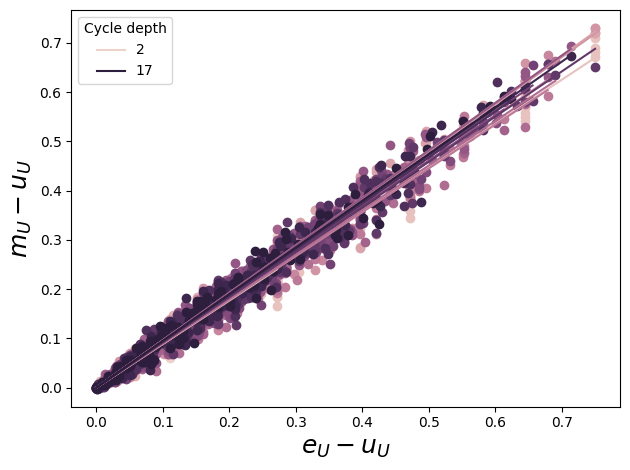

In [19]:
%matplotlib inline
from matplotlib import pyplot as plt

# Color by cycle depth
import seaborn as sns

colors = sns.cubehelix_palette(n_colors=len(depths))
colors = {k: colors[i] for i, k in enumerate(depths)}

_lines = []


def per_cycle_depth(df):
    fid_lsq = df["numerator"].sum() / df["denominator"].sum()

    cycle_depth = df.name
    xx = np.linspace(0, df["x"].max())
    (l,) = plt.plot(xx, fid_lsq * xx, color=colors[cycle_depth])
    plt.scatter(df["x"], df["y"], color=colors[cycle_depth])

    global _lines
    _lines += [l]  # for legend
    return pd.Series({"fidelity": fid_lsq})


fids = df.groupby("depth").apply(per_cycle_depth).reset_index()
plt.xlabel(r"$e_U - u_U$", fontsize=18)
plt.ylabel(r"$m_U - u_U$", fontsize=18)
_lines = np.asarray(_lines)
plt.legend(_lines[[0, -1]], depths[[0, -1]], loc="best", title="Cycle depth")
plt.tight_layout()

NameError: name 'a_fit2' is not defined

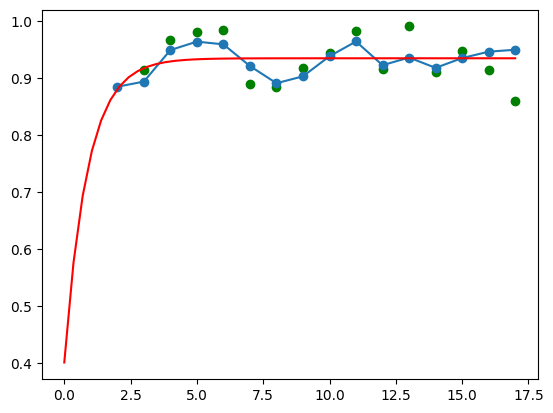

In [20]:
# Fit the data
def exponential_decay(x, a, b, c):
    return a * np.exp(-b * x) + c


# In XEB, we extract the depolarizing fidelity, which is
# related to (but not equal to) the Pauli error.
# For the latter, an error involves doing X, Y, or Z with E_PAULI/3
# but for the former, an error involves doing I, X, Y, or Z with e_depol/4
try:
    params, covariance = curve_fit(exponential_decay, depths, fids["fidelity"])
    a_fit1, b_fit1, c_fit1 = params
    x = exponential_decay(depths, a_fit1, b_fit1, c_fit1)
    xeb_err_per_cycle1 = 1 - (x[2] - c_fit1) / (x[1] - c_fit1)
except:
    pass
Fxeb = np.mean(fidelities, axis=0)
try:
    params2, covariance2 = curve_fit(exponential_decay, depths, Fxeb)
    a_fit2, b_fit2, c_fit2 = params2
    x2 = exponential_decay(depths, a_fit2, b_fit2, c_fit2)
    xeb_err_per_cycle2 = 1 - (x2[2] - c_fit2) / (x2[1] - c_fit2)
except:
    pass

plt.plot(fids["depth"], fids["fidelity"], marker="o", label="Google processing")
xx = np.linspace(0, fids["depth"].max())

plt.plot(xx, exponential_decay(xx, a_fit1, b_fit1, c_fit1),
         label='Fit (Google processing), err_per_cycle={:.2f}'.format(xeb_err_per_cycle1),
         color='red')

plt.scatter(depths, Fxeb, marker = 'o',
            color='green', label="Log-entropy processing")
plt.plot(
    xx,
    exponential_decay(xx, a_fit2, b_fit2, c_fit2),
    label="Fit (Log-entropy processing), err_per_cycle={:.2f}".format(xeb_err_per_cycle2),
    color="green",
)
plt.ylabel("Circuit fidelity", fontsize=20)
plt.xlabel("Cycle Depth $d$", fontsize=20)
plt.title("XEB Fidelity")
plt.legend(loc="best")
# plt.yscale("log")
plt.tight_layout()

In [21]:
print(a_fit1, b_fit1, c_fit1)
print(a_fit2, b_fit2, c_fit2)
print(xeb_err_per_cycle1, xeb_err_per_cycle2)

-0.5336000997812564 1.143022619999701 0.9340555565663553


NameError: name 'a_fit2' is not defined

In [22]:
fids["fidelity"] # Google processing

0     0.884151
1     0.893132
2     0.948461
3     0.963251
4     0.958460
5     0.920444
6     0.890306
7     0.902388
8     0.937654
9     0.963482
10    0.921904
11    0.935350
12    0.917233
13    0.934395
14    0.945634
15    0.949000
Name: fidelity, dtype: float64

In [285]:
Fxeb # Derived from the paper

array([       nan, 0.90758299, 1.0115637 , 0.96947721, 0.93036591,
       0.93180437, 0.907753  , 0.89358554, 0.95244323, 0.96913138,
       0.95053662, 0.92074976, 0.90751682, 1.13450445, 0.96575821,
       0.94607457, 0.9585897 , 0.94348577, 0.9159033 ])

In [23]:
print("relative difference", np.abs(fids["fidelity"] - Fxeb))

relative difference 0          NaN
1     0.019788
2     0.017507
3     0.016632
4     0.026003
5     0.031980
6     0.007145
7     0.013985
8     0.006002
9     0.018849
10    0.005904
11    0.054481
12    0.007520
13    0.012415
14    0.032507
15    0.089095
Name: fidelity, dtype: float64


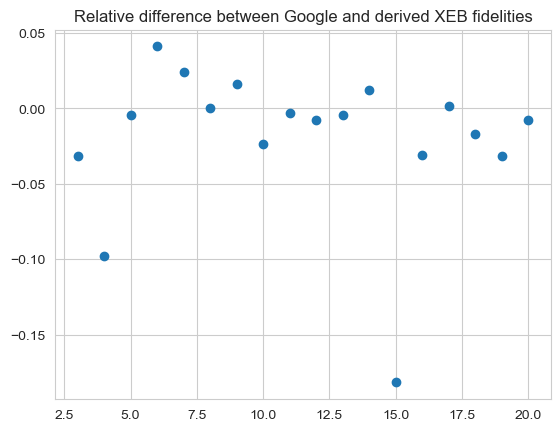

In [302]:
plt.title("Relative difference between Google and derived XEB fidelities")
plt.plot(depths, (fids["fidelity"]-Fxeb)/Fxeb, 'o', label="XEB fidelity")
